In [1]:
#读取数据
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [4]:
#reduce_mam_usage函数通过调整数据类型，帮助减少数据在内存中占用的空间
def reduce_mam_usage(df):
    '''iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum()
    print('memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum()
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
sample_feature = reduce_mam_usage(pd.read_csv('data_for_tree.csv'))


memory usage of dataframe is 62400080.00 MB


Memory usage after optimization is: 16600184.00 MB
Decreased by 73.4%


In [6]:
continuous_feature_names = [x for x in sample_feature.columns if x not in['price','brand','model','brand']]

In [13]:
##线性回归 & 五折交叉验证 & 模拟真实业务情况
sample_feature = sample_feature.dropna().replace('-',0).reset_index(drop=True)
sample_feature['notRepairedDamage']=sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names+['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

In [14]:
#简单建模
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model = model.fit(train_X,train_y)

In [15]:
#查看训练的线性回归模型的截距和权重
'intercept:'+str(model.intercept_)
sorted(dict(zip(continuous_feature_names,model.coef_)).items(),key=lambda x:x[1],reverse=True)


[('v_6', 3229116.1626684084),
 ('v_8', 674807.8363909571),
 ('v_9', 164786.12796313874),
 ('v_7', 30009.316315493103),
 ('v_12', 22560.046684521738),
 ('v_3', 19507.780195921638),
 ('v_13', 12464.02838409637),
 ('v_11', 11379.865216384815),
 ('v_10', 3419.563465137771),
 ('gearbox', 873.1398564596966),
 ('fuelType', 345.60437551205064),
 ('bodyType', 183.53098755623373),
 ('city', 49.031640748283465),
 ('power', 30.225159310686774),
 ('brand_price_median', 0.4464224393424219),
 ('brand_amount', 0.14498544442280273),
 ('brand_price_std', 0.12500996262682101),
 ('brand_price_max', 0.012048529537467713),
 ('offerType', 6.892485544085503e-06),
 ('train', 0.0),
 ('SaleID', -4.395103702878963e-06),
 ('seller', -4.780478775501251e-06),
 ('brand_price_sum', -2.0049520806188984e-05),
 ('name', -0.00016773868801384936),
 ('used_time', -0.025285112900395854),
 ('brand_price_average', -0.20429566645993202),
 ('brand_price_min', -2.0158248292619225),
 ('power_bin', -54.23422645146429),
 ('kilometer

In [17]:
from matplotlib import pyplot as plt

subsample_index = np.random.randint(low=0,high=len(train_y),size=50)

the predicted price is obvious different from true price


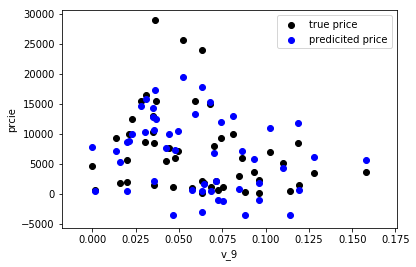

In [18]:
#绘制特征v_9的值与标签的散点图，图片发现模型的预测结果（蓝色点）与真实标签（黑色点）的分布差异较大，
# 且部分预测值出现了小于0的情况，说明我们的模型存在一些问题
plt.scatter(train_X['v_9'][subsample_index],train_y[subsample_index],color='black')
plt.scatter(train_X['v_9'][subsample_index],model.predict(train_X.loc[subsample_index]),color='blue')
plt.xlabel('v_9')
plt.ylabel('prcie')
plt.legend(['true price','predicited price'],loc='upper right')
print('the predicted price is obvious different from true price')
plt.show()

it is clear to see the price shows a typical exponential distribution


E:\2installstion_path\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


AttributeError: module 'numpy' has no attribute 'quantile'

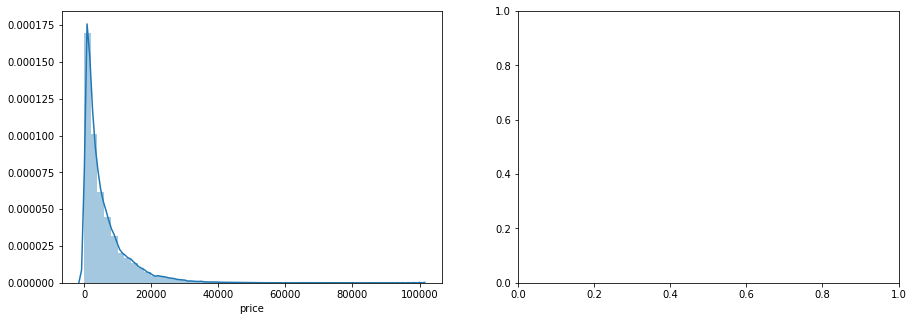

In [19]:
import seaborn as sns
print('it is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y,0.9)])

the transformed price seems like normal distribution


E:\2installstion_path\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


AttributeError: module 'numpy' has no attribute 'quantile'

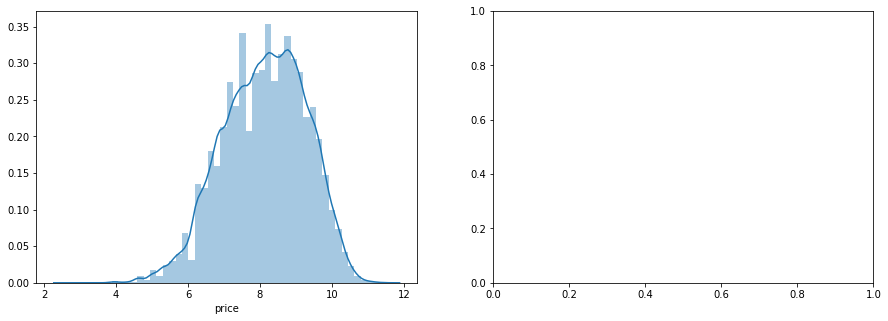

In [20]:
#在这里我们对标签进行了 $log(x+1)$ 变换，使标签贴近于正态分布
train_y_ln = np.log(train_y +1 )

import seaborn as sns
print('the transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln,0.9)])

In [21]:
model = model.fit(train_X,train_y_ln)
print('intercept:' +str(model.intercept_))
sorted(dict(zip(continuous_feature_names,model.coef_)).items(),key=lambda x:x[1],reverse=True)


intercept:17.796278051864093


[('v_9', 8.426220757485114),
 ('v_5', 7.111476691647461),
 ('v_1', 1.3594809666822039),
 ('v_7', 0.8315591860146065),
 ('v_13', 0.7690288705454851),
 ('v_12', 0.505212102905853),
 ('v_11', 0.4884627181164143),
 ('v_2', 0.23613949854456),
 ('v_3', 0.06605836705725045),
 ('v_0', 0.012401348945647643),
 ('power_bin', 0.009564582920978672),
 ('gearbox', 0.007295656104245682),
 ('fuelType', 0.004617709244820998),
 ('bodyType', 0.004204165061073822),
 ('v_14', 0.0041096152077201905),
 ('power', 0.0005841853762389082),
 ('brand_price_min', 3.16978392955591e-05),
 ('brand_price_std', 2.5222536863027227e-06),
 ('brand_price_median', 1.94075334446292e-06),
 ('brand_amount', 1.9405206742489e-06),
 ('brand_price_max', 1.4907760901657598e-07),
 ('SaleID', 9.328283376370306e-09),
 ('seller', 1.000266536266281e-10),
 ('brand_price_sum', 7.500835692683746e-11),
 ('offerType', 2.006572685786523e-11),
 ('train', 2.3874235921539366e-12),
 ('name', -7.832402007677123e-08),
 ('brand_price_average', -8.8379

the predicted price seems normal after np.log transforming


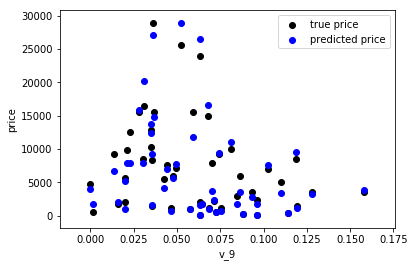

In [23]:
#再次进行可视化，发现预测结果与真实值比较接近，且未出现异常情况
plt.scatter(train_X['v_9'][subsample_index],train_y[subsample_index],color='black')
plt.scatter(train_X['v_9'][subsample_index],np.exp(model.predict(train_X.loc[subsample_index])),color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['true price','predicted price'],loc='upper right')
print('the predicted price seems normal after np.log transforming')
plt.show()

In [25]:
#五折交叉验证
#在使用训练集对参数进行训练的时候，经常会发现人们通常会将一整个训练集分为三个部分（比如mnist手写训练集）。
# 一般分为：训练集（train_set），评估集（valid_set），测试集（test_set）这三个部分。
# 这其实是为了保证训练效果而特意设置的。其中测试集很好理解，其实就是完全不参与训练的数据，仅仅用来观测测试效果的数据。
# 而训练集和评估集则牵涉到下面的知识了。
#因为在实际的训练中，训练的结果对于训练集的拟合程度通常还是挺好的（初始条件敏感），但是对于训练集之外的数据的拟合程度通常就不那么令人满意了。
# 因此我们通常并不会把所有的数据集都拿来训练，而是分出一部分来（这一部分不参加训练）对训练集生成的参数进行测试，相对客观的判断这些参数对训练集之外的数据的符合程度。
# 这种思想就称为交叉验证（Cross Validation）
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,make_scorer

In [26]:
def log_transfer(func):
    def wrapper(y,yhat):
        result = func(np.log(y),np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [30]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s finished


In [33]:
#使用线性回归模型，对未处理标签的特征数据进行五折交叉验证（Error 1.36）
print('avg:',np.mean(scores))

avg: 0.193505206439065


In [34]:
#使用线性回归模型，对处理过标签的特征数据进行五折交叉验证（Error 0.19）
scores=cross_val_score(model,X=train_X,y=train_y_ln,verbose=1,cv=5,scoring=make_scorer(mean_absolute_error))


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.0s finished


In [35]:
print('avg:',np.mean(scores))


avg: 0.193505206439065


In [38]:

#scores=pd.DataFrame(scores.reshape(1,-1))
scores.columns=['cv'+str(x) for x in range(1,6)]
scores.index=['mae']
scores

,cv1,cv2,cv3,cv4,cv5
mae,0.19104,0.193719,0.194442,0.191812,0.196514


In [39]:
#模拟真实业务情况
#但在事实上，由于我们并不具有预知未来的能力，五折交叉验证在某些与时间相关的数据集上反而反映了不真实的情况。
# 通过2018年的二手车价格预测2017年的二手车价格，这显然是不合理的，因此我们还可以采用时间顺序对数据集进行分隔。
# 在本例中，我们选用靠前时间的4/5样本当作训练集，靠后时间的1/5当作验证集，最终结果与五折交叉验证差距不大

import datetime
sample_feature=sample_feature.reset_index(drop=True)
split_point=len(sample_feature) // 5 * 4

train=sample_feature.loc[:split_point].dropna()
val=sample_feature.loc[split_point:].dropna()

train_X=train[continuous_feature_names]
train_y_ln=np.log(train['price']+1)
val_X=val[continuous_feature_names]
val_y_ln=np.log(val['price']+1)

In [40]:
model=model.fit(train_X,train_y_ln)

In [41]:
mean_absolute_error(val_y_ln,model.predict(val_X))

0.19651363256395923

In [42]:
#绘制学习率曲线与验证曲线
from sklearn.model_selection import learning_curve,validation_curve


In [43]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt 

<module 'matplotlib.pyplot' from 'E:\\2installstion_path\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

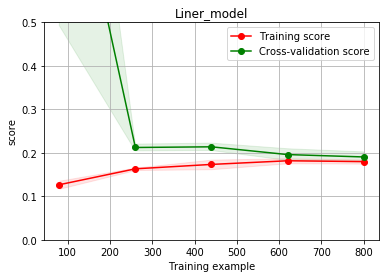

In [44]:
plot_learning_curve(LinearRegression(),'Liner_model',train_X[:1000],train_y_ln[:1000],ylim=(0.0,0.5),cv=5,n_jobs=1)


In [45]:
#多种模型对比
train=sample_feature[continuous_feature_names+['price']].dropna()

train_X=train[continuous_feature_names]
train_y=train['price']
train_y_ln=np.log(train_y+1)

In [46]:
# 1 线性模型 & 嵌入式特征选择
# 本章节默认，学习者已经了解关于过拟合、模型复杂度、正则化等概念。
# 否则请寻找相关资料或参考如下连接：
# 用简单易懂的语言描述「过拟合 overfitting」？ https://www.zhihu.com/question/32246256/answer/55320482
# 模型复杂度与模型的泛化能力 http://yangyingming.com/article/434/
# 正则化的直观理解 https://blog.csdn.net/jinping_shi/article/details/52433975
# 在过滤式和包裹式特征选择方法中，特征选择过程与学习器训练过程有明显的分别。而嵌入式特征选择在学习器训练过程中自动地进行特征选择。嵌入式选择最常用的是L1正则化与L2正则化。在对线性回归模型加入两种正则化方法后，他们分别变成了岭回归与Lasso回归。
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import  Lasso


In [47]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [48]:
result=dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model,X=train_X,y=train_y_ln,verbose=0,cv=5,scoring=make_scorer(mean_absolute_error))
    result[model_name]=scores
    print(model_name+'is finished')

LinearRegressionis finished


Ridgeis finished


Lassois finished


In [50]:
#对三种方法的效果对比
result=pd.DataFrame(result)
result.index=['cv'+str(x) for x in range(1,6)]
print(result)

     LinearRegression     Ridge     Lasso
cv1          0.191041  0.195110  0.390614
cv2          0.193719  0.197760  0.390910
cv3          0.194442  0.198597  0.391883
cv4          0.191812  0.195762  0.387536
cv5          0.196514  0.200577  0.391316


intercept:17.796222069593398


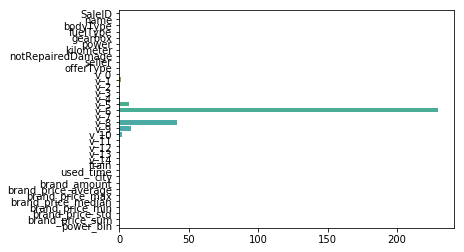

In [51]:
model = LinearRegression().fit(train_X,train_y_ln)
print('intercept:'+str(model.intercept_))
sns.barplot(abs(model.coef_),continuous_feature_names)

intercept:4.239562601415325


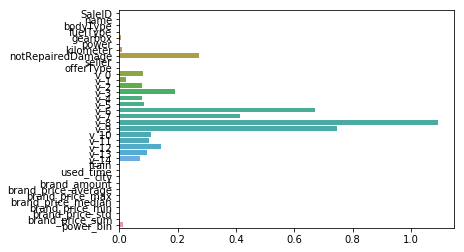

In [52]:
#L2正则化在拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型。
# 因为一般认为参数值小的模型比较简单，能适应不同的数据集，也在一定程度上避免了过拟合现象。
# 可以设想一下对于一个线性回归方程，若参数很大，那么只要数据偏移一点点，就会对结果造成很大的影响；
# 但如果参数足够小，数据偏移得多一点也不会对结果造成什么影响，专业一点的说法是『抗扰动能力强』.
model=Ridge().fit(train_X,train_y_ln)
print('intercept:'+str(model.intercept_))
sns.barplot(abs(model.coef_),continuous_feature_names)

intercept:8.806643706469927


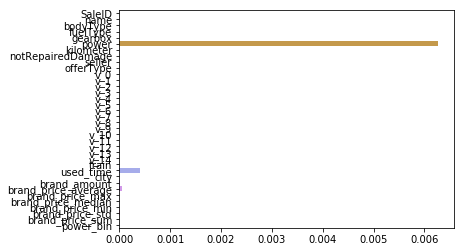

In [53]:
#L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择。如下图，我们发现power与userd_time特征非常重要。
model = Lasso().fit(train_X,train_y_ln)
print('intercept:'+str(model.intercept_))
sns.barplot(abs(model.coef_),continuous_feature_names)

In [54]:
# 2 非线性模型
# 除了线性模型以外，还有许多我们常用的非线性模型如下，在此篇幅有限不再一一讲解原理。我们选择了部分常用模型与线性模型进行效果比对。
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [55]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs',max_iter=100),
          XGBRegressor(n_estimators=100,objective='reg:squarederror'),
          LGBMRegressor(n_estimators=100)]

In [57]:
result=dict()
for model in models:
    model_name=str(model).split('(')[0]
    scores = cross_val_score(model,X=train_X,y=train_y_ln,verbose=0,cv=5,scoring=make_scorer(mean_absolute_error))
    result[model_name]=scores
    print(model_name+'is finished')

LinearRegressionis finished


DecisionTreeRegressoris finished


RandomForestRegressoris finished


GradientBoostingRegressoris finished


MLPRegressoris finished


XGBRegressoris finished


LGBMRegressoris finished


In [59]:
result=pd.DataFrame(result)
result.index=['cv'+str(x) for x in range(1,6)]
print(result)

     LinearRegression  DecisionTreeRegressor  RandomForestRegressor  \
cv1          0.191041               0.201165               0.142130   
cv2          0.193719               0.191705               0.141833   
cv3          0.194442               0.189652               0.142654   
cv4          0.191812               0.191647               0.141040   
cv5          0.196514               0.200360               0.146791   

     GradientBoostingRegressor  MLPRegressor  XGBRegressor  LGBMRegressor  
cv1                   0.168213   3005.956749      0.137943       0.140764  
cv2                   0.171069    560.575508      0.139930       0.144214  
cv3                   0.170937    329.801183      0.138958       0.142438  
cv4                   0.169275   4201.603945      0.137497       0.141543  
cv5                   0.171918   1899.843664      0.142777       0.144925  


In [60]:
##模型调参
# 在此我们介绍了三种常用的调参方法如下：

# 贪心算法 https://www.jianshu.com/p/ab89df9759c8
# 网格调参 https://blog.csdn.net/weixin_43172660/article/details/83032029
# 贝叶斯调参 https://blog.csdn.net/linxid/article/details/81189154


In [61]:
##LGB的参数集合：
objective = ['regression','regression_11','mape','huber','fair']
num_leaves = [3,5,10,15,20,40,55]
max_depth = [3,5,10,15,20,40,55]
bagging_fraction=[]
feature_fraction=[]
drop_rate=[]

In [62]:
## 1 贪心调参
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model,X=train_X,y=train_y_ln,verbose=0,cv=5,scoring=make_scorer(mean_absolute_error)))
    best_obj[obj]=score

best_leaves=dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(),key=lambda x:x[1])[0],num_leaves=leaves)
    score = np.mean(cross_val_score(model,X=train_X,y=train_y_ln,verbose=0,cv=5,scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves]=score

best_depth=dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(),key=lambda  x:x[1])[0],
                          num_leaves=min(best_leaves.items(),key=lambda x:x[1])[0],
                          max_depth=depth)
    score= np.mean(cross_val_score(model,X=train_X,y=train_y_ln,verbose=0,cv=5,scoring=make_scorer(mean_absolute_error)))
    best_depth[depth]=score

In [65]:
#sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'],
 #            y=[0.143,min(best_obj.values()),min(best_leaves.values()),min(best_depth.values())])
#sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

In [66]:
#2 Grid Search 调参
from sklearn.model_selection import GridSearchCV


In [68]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

In [74]:
#clf.best_params

In [75]:
model=LGBMRegressor(objective='regression',num_leaves=55,max_dept=15)

In [76]:
np.mean(cross_val_score(model,X=train_X,y=train_y_ln,verbose=0,cv=5,scoring=make_scorer(mean_absolute_error)))

0.13711677065191444

In [78]:
#总结
# 在本章中，我们完成了建模与调参的工作，并对我们的模型进行了验证。
# 此外，我们还采用了一些基本方法来提高预测的精度，提升如下图所示。
#plt.figure(figsize=(13,5))
#sns.lineplot(x=['0_origin','1_log_transfer','2_L1_&_L2','3_change_model','4_parameter_turning'],y=[1.36,0.19,0.19,0.14,0.13])
